In [1]:
# Importing NumPy for numerical operations
import numpy as np

# Importing TensorFlow and Keras for deep learning functionalities
import tensorflow as tf
from tensorflow.python.keras import models, losses, layers, backend as K
import keras.preprocessing.image as process_im
from keras.applications import vgg19
from keras.models import Model

# Importing PIL (Python Imaging Library) for working with images
from PIL import Image

# Importing Matplotlib for plotting graphs and visualizations
import matplotlib.pyplot as plt

# Importing functools for functional programming tools
import functools

# Importing IPython.display for displaying images in the IPython environment
import IPython.display

# Importing tqdm for displaying progress bars during iterations
from tqdm import tqdm

In [2]:
# File path for the content image
content_path = '/content/download (4).jpeg'

# File path for the style image
style_path = '/content/download (3).jpeg'

In [3]:
def load_file(image_path):
    """
    Load an image from the specified file path, resize it, and convert it to a NumPy array.

    Parameters:
    - image_path (str): The file path of the image to be loaded.

    Returns:
    - numpy.ndarray: A NumPy array representing the processed image.
    """

    # Open the image using PIL (Python Imaging Library)
    image = Image.open(image_path)

    # Resize the image while maintaining its aspect ratio
    max_dim = 512
    factor = max_dim / max(image.size)
    image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.ANTIALIAS)

    # Convert the resized image to a NumPy array
    im_array = process_im.img_to_array(image)

    # Add an extra dimension to the array to represent the batch size
    im_array = np.expand_dims(im_array, axis=0)

    return im_array


In [4]:
def show_im(img, title=None):
    """
    Display an image using Matplotlib.

    Parameters:
    - img (numpy.ndarray): The image represented as a NumPy array.
    - title (str, optional): The title to be displayed above the image. Defaults to None.
    """

    # Remove the batch dimension if present
    img = np.squeeze(img, axis=0)

    # Display the image using Matplotlib
    plt.imshow(np.uint8(img))

    # Set the title if provided
    if title is not None:
        plt.title(title)

    # Show the image
    plt.show()

In [5]:
# Load the content image using the load_file function
content = load_file(content_path)

# Load the style image using the load_file function
style = load_file(style_path)

<ipython-input-3-526e3d8d39f6>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.ANTIALIAS)


<ipython-input-3-526e3d8d39f6>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.ANTIALIAS)


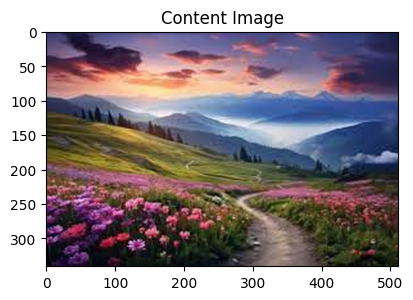

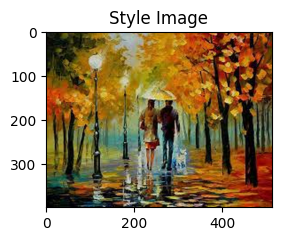

In [6]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [7]:
def img_preprocess(img_path):
    """
    Preprocess an image using the VGG19 preprocessing method.

    Parameters:
    - img_path (str): The file path of the image to be preprocessed.

    Returns:
    - numpy.ndarray: The preprocessed image as a NumPy array.
    """
    # Load the image using the load_file function
    image = load_file(img_path)

    # Preprocess the image using the VGG19 preprocessing method
    preprocessed_img = tf.keras.applications.vgg19.preprocess_input(image)

    return preprocessed_img

In [8]:
def deprocess_img(processed_img):
    """
    Reverse the preprocessing applied to an image.

    Parameters:
    - processed_img (numpy.ndarray): The preprocessed image as a NumPy array.

    Returns:
    - numpy.ndarray: The deprocessed image as a NumPy array.
    """
    x = processed_img.copy()

    # If the image has a batch dimension, remove it
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    # Ensure that the image has three dimensions
    assert len(x.shape) == 3

    # Reverse the VGG19 preprocessing adjustments
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Reverse the channel order (BGR to RGB)
    x = x[:, :, ::-1]

    # Clip pixel values to the valid range [0, 255] and convert to uint8
    x = np.clip(x, 0, 255).astype('uint8')

    return x

In [9]:
im=img_preprocess(content_path)

<ipython-input-3-526e3d8d39f6>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.ANTIALIAS)


In [10]:
# List of layers used for content extraction
content_layers = ['block5_conv2']

# List of layers used for style extraction
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Calculate the number of content and style layers
number_content = len(content_layers)
number_style = len(style_layers)

In [11]:
def get_model():
    """
    Create a model for neural style transfer based on VGG19 architecture.

    Returns:
    - tensorflow.keras.models.Model: The constructed model for neural style transfer.
    """
    # Load the VGG19 model with pre-trained weights
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

    # Make the VGG19 layers non-trainable
    vgg.trainable = False

    # Get the output tensors for the specified content layers
    content_output = [vgg.get_layer(layer).output for layer in content_layers]

    # Get the output tensors for the specified style layers
    style_output = [vgg.get_layer(layer).output for layer in style_layers]

    # Combine style and content outputs to form the final model output
    model_output = style_output + content_output

    # Create a new model with the specified input and output tensors
    return models.Model(vgg.input, model_output)

In [12]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
def get_content_loss(noise, target):
    """
    Calculate the content loss between two feature representations.

    Parameters:
    - noise (tf.Tensor): Feature representation of the generated image.
    - target (tf.Tensor): Feature representation of the target content image.

    Returns:
    - tf.Tensor: The content loss.
    """
    loss = tf.reduce_mean(tf.square(noise - target))
    return loss


def gram_matrix(tensor):
    """
    Calculate the Gram matrix for a given tensor.

    Parameters:
    - tensor (tf.Tensor): The input tensor.

    Returns:
    - tf.Tensor: The Gram matrix.
    """
    channels = int(tensor.shape[-1])
    vector = tf.reshape(tensor, [-1, channels])
    n = tf.shape(vector)[0]
    gram_matrix = tf.matmul(vector, vector, transpose_a=True)
    return gram_matrix / tf.cast(n, tf.float32)


def get_style_loss(noise, target):
    """
    Calculate the style loss between two Gram matrices.

    Parameters:
    - noise (tf.Tensor): Gram matrix of the generated image.
    - target (tf.Tensor): Gram matrix of the target style image.

    Returns:
    - tf.Tensor: The style loss.
    """
    gram_noise = gram_matrix(noise)
    loss = tf.reduce_mean(tf.square(target - gram_noise))
    return loss


def get_features(model, content_path, style_path):
    """
    Extract content and style features from specified layers of a model.

    Parameters:
    - model (tf.keras.models.Model): The neural network model.
    - content_path (str): File path of the content image.
    - style_path (str): File path of the style image.

    Returns:
    - Tuple: Content features and style features.
    """
    content_img = img_preprocess(content_path)
    style_image = img_preprocess(style_path)

    content_output = model(content_img)
    style_output = model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature, style_feature


def compute_loss(model, loss_weights, image, gram_style_features, content_features):
    """
    Compute the total loss, style loss, and content loss for an image.

    Parameters:
    - model (tf.keras.models.Model): The neural network model.
    - loss_weights (Tuple): Weights for style and content losses.
    - image (tf.Tensor): The generated image.
    - gram_style_features (List): Gram matrices of style features.
    - content_features (List): Content features.

    Returns:
    - Tuple: Total loss, style loss, and content loss.
    """
    style_weight, content_weight = loss_weights
    output = model(image)
    content_loss = 0
    style_loss = 0

    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]

    weight_per_layer = 1.0 / float(number_style)
    for a, b in zip(gram_style_features, noise_style_features):
        style_loss += weight_per_layer * get_style_loss(b[0], a)

    weight_per_layer = 1.0 / float(number_content)
    for a, b in zip(noise_content_feature, content_features):
        content_loss += weight_per_layer * get_content_loss(a[0], b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss

    return total_loss, style_loss, content_loss


def compute_grads(dictionary):
    """
    Compute gradients of the total loss with respect to the image.

    Parameters:
    - dictionary (Dict): Dictionary containing model, loss_weights, image, gram_style_features, and content_features.

    Returns:
    - Tuple: Gradients and the total loss.
    """
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**dictionary)

    total_loss = all_loss[0]
    return tape.gradient(total_loss, dictionary['image']), all_loss

In [14]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [15]:
def run_style_transfer(content_path, style_path, epochs=500, content_weight=1e3, style_weight=1e-2):
    """
    Run neural style transfer algorithm to generate an image with the style of one image and content of another.

    Parameters:
    - content_path (str): File path of the content image.
    - style_path (str): File path of the style image.
    - epochs (int): Number of optimization iterations. Defaults to 500.
    - content_weight (float): Weight for the content loss. Defaults to 1e3.
    - style_weight (float): Weight for the style loss. Defaults to 1e-2.

    Returns:
    - Tuple: Best stylized image, best loss, and a list of images for visualization during training.
    """
    # Get the model for neural style transfer
    model = get_model()

    # Set all layers in the model to be non-trainable
    for layer in model.layers:
        layer.trainable = False

    # Extract content and style features from the input images
    content_feature, style_feature = get_features(model, content_path, style_path)

    # Compute Gram matrices for style features
    style_gram_matrix = [gram_matrix(feature) for feature in style_feature]

    # Initialize the generated image (noise) from the content image
    noise = img_preprocess(content_path)
    noise = tf.Variable(noise, dtype=tf.float32)

    # Set up the Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # Initialize variables for tracking the best loss and best generated image
    best_loss, best_img = float('inf'), None

    # Set up dictionary with parameters for loss computation
    loss_weights = (style_weight, content_weight)
    dictionary = {
        'model': model,
        'loss_weights': loss_weights,
        'image': noise,
        'gram_style_features': style_gram_matrix,
        'content_features': content_feature
    }

    # Normalize means for clipping generated image
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    # List to store images for visualization during training
    imgs = []

    # Training loop
    for i in tqdm(range(epochs)):
        grad, all_loss = compute_grads(dictionary)
        total_loss, style_loss, content_loss = all_loss

        # Apply gradients to update the generated image
        optimizer.apply_gradients([(grad, noise)])

        # Clip the pixel values of the generated image
        clipped = tf.clip_by_value(noise, min_vals, max_vals)
        noise.assign(clipped)

        # Update best loss and best generated image if the current loss is lower
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())

        # For visualization every 5 epochs
        if i % 5 == 0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, style loss: {:.4e}, content loss: {:.4e}'.format(total_loss, style_loss, content_loss))

    IPython.display.clear_output(wait=True)

    return best_img, best_loss, imgs


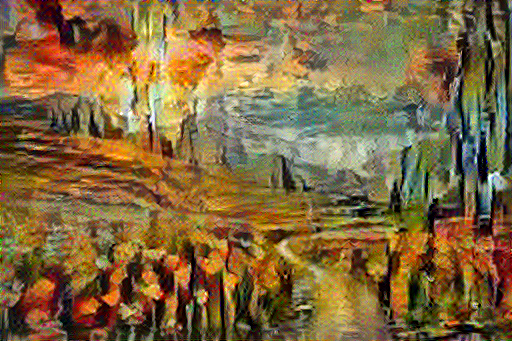

100%|█████████▉| 997/1000 [02:24<00:00,  7.19it/s]

Epoch: 995
Total loss: 7.2109e+05, style loss: 2.2214e+05, content loss: 4.9895e+05


100%|██████████| 1000/1000 [02:24<00:00,  6.90it/s]


In [16]:
best, best_loss,image = run_style_transfer(content_path,
                                     style_path, epochs=1000)